Since last week, I'm looking for a new appartment in Paris. Also, I'm on sick-leave from work this work. So let's use this as an excuse to get some data from the internet and make some nice looking maps and plots that analyse the renting market in Paris!
The outline of this notebook will be:

- gathering the data, by scraping a well-known French website for appartment rentals
    - first building a prototype
    - then scraping the full query from the website
- analyzing the data by plotting it, in several formats
    - regression plots
    - categorical plots
    - geographical choropleths
    
    
Let's get started!

# Getting the data: prototyping

We will get our data from the French website [seloger.com](http://www.seloger.com). I'm not sure this is a feature or a bug, but the website search pages ship with an array of JSON data which is exactly what we want if we would like to do some maps. So, to get the data, we download the search page using requests and then we parse it with BeautifulSoup. 

Let's see how this works with an example. I just made a query for all two-room appartments available inside Paris.

In [1]:
url = 'http://www.seloger.com/list.htm?org=advanced_search&idtt=1&idtypebien=1&cp=75&tri=initial&nb_pieces=2&naturebien=1,2,4'

Let's download the webpage. Side note: we have to pretend we're a browser, not a robot [using custom headers](https://stackoverflow.com/questions/27652543/how-to-use-python-requests-to-fake-a-browser-visit).

In [2]:
headers = {'User-Agent': '*',
'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
'Accept-Language': 'en-US,en;q=0.5',
'Accept-Encoding': 'gzip, deflate',
'Connection': 'keep-alive',
'Upgrade-Insecure-Requests': '1'}

In [3]:
import requests

In [4]:
s = requests.Session()
s.headers.update(headers)
s.get('http://www.seloger.com/')

<Response [200]>

In [5]:
r = s.get(url)
r

<Response [200]>

And parse it:

In [7]:
from bs4 import BeautifulSoup

In [8]:
soup = BeautifulSoup(r.text, 'html.parser')

I can find a tag which contains raw JSON:

In [9]:
for script_item in soup.find_all('script'):
    if 'var ava_data' in script_item.text:
        raw_json = script_item.text.split('=')[1][:-25]

In [10]:
raw_json[:400]

' \r\n\r\n\r\n\r\n\r\n\r\n    \r\n    \r\n\r\n    \r\n    \r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n{\r\n    "search" : {\r\n        "levier" : "Recherche depuis la liste",\r\n        "nbresults" : "2\xa0158",\r\n        "nbpage" : "1",\r\n        "typedetransaction" : ["location"],\r\n        "nbpieces" : ["2"],\r\n        "typedebien" : ["Appartement"],\r\n        "pays" : "F'

Which I can transform into a dictionary, since it's JSON:

In [11]:
import json

In [12]:
data = json.loads(raw_json)

And feed into a dataframe:

In [13]:
import pandas as pd

In [14]:
data.keys()

dict_keys(['search', 'products'])

In [15]:
df = pd.DataFrame(data['products'])

In [16]:
df.head(10)

,affichagetype,codeinsee,codepostal,cp,etage,idagence,idannonce,idtiers,idtypechauffage,idtypecommerce,...,nb_pieces,position,prix,produitsvisibilite,si_balcon,si_sdEau,si_sdbain,surface,typedebien,typedetransaction
0,"[{'name': 'list', 'value': True}]",750118,75018,75018,2,481,124015305,122982,central radiateur,0,...,2,0,970,AD:AC:AG:BB:BX:AW,0,0,1,42,Appartement,[location]
1,"[{'name': 'list', 'value': True}]",750120,75020,75020,1,109745,124073427,165465,0,0,...,2,1,1015,AD:AC:AG:BB:AW,0,0,0,26,Appartement,[location]
2,"[{'name': 'list', 'value': True}]",750119,75019,75019,2,36283,123618371,136353,0,0,...,2,2,1222,AD:AC:BB:BX:AW,0,1,0,"54,1",Appartement,[location]
3,"[{'name': 'list', 'value': True}]",750116,75016,75016,7,1509,123616423,66095,central,0,...,2,3,1100,AD:AC:AH:BB:BX:AW,0,1,0,40,Appartement,[location]
4,"[{'name': 'list', 'value': True}]",750115,75015,75015,5,1097,123594453,136882,gaz,0,...,2,4,1456,AD:AC:AG:BB:BX:AW,0,0,0,"46,04",Appartement,[location]
5,"[{'name': 'list', 'value': True}]",750115,75015,75015,5,50643,123580081,78276,central,0,...,2,5,1495,AD:AC:AG:BB:AW,1,0,1,"54,02",Appartement,[location]
6,"[{'name': 'list', 'value': True}]",750118,75018,75018,4,109745,120725333,165465,0,0,...,2,6,1420,AD:AC:AG:BB:AW,0,1,1,"37,43",Appartement,[location]
7,"[{'name': 'list', 'value': True}]",750107,75007,75007,1,60741,123841041,65362,0,0,...,2,7,1500,AD:AC:AG:BB:BX:AW,0,0,0,44,Appartement,[location]
8,"[{'name': 'list', 'value': True}]",750116,75116,75116,2,35635,123643103,26189,individuel électrique,0,...,2,8,1600,AD:AC:AG:BB:AW,0,0,1,53,Appartement,[location]
9,"[{'name': 'list', 'value': True}]",750116,75016,75016,3,43088,123737121,18264,central,0,...,2,9,1500,AD:AC:AH:AG:BB:AW,1,0,1,58,Appartement,[location]


There we go! We have some data. We can then plot this after a little bit of formatting:

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np

In [18]:
import numpy as np

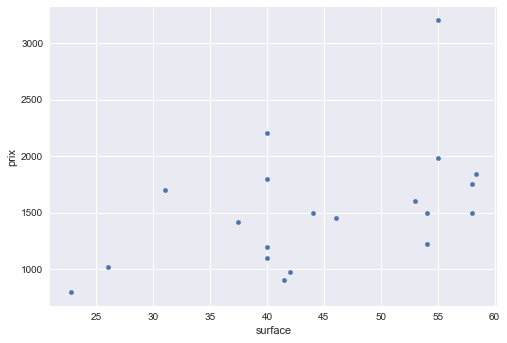

In [20]:
formatted = df.dropna()
numeric_series = ['surface', 'prix']
for series in numeric_series:
    formatted[series] = pd.to_numeric(formatted[series].str.replace(',', '.'))
formatted.plot.scatter(x='surface', y='prix')

# Getting the data: for-looping 

Of course, we're just scratching the edge here since we only have twenty data points. Let's write a for loop that allows us to extract all information for the 2000+ available appartments.

We can find the url of the next page button with this code:

In [21]:
next_page = soup.find('div', class_='pagination-number').find('a').attrs['href']
next_page

'http://www.seloger.com/list.htm?org=advanced_search&idtt=1&idtypebien=1&cp=75&tri=initial&nb_pieces=2&naturebien=1,2,4&LISTING-LISTpg=2'

All it takes for us to generate the links to all pages is to replace that `2` by another number and to know what the last one is. 

The number of appartments is easy to find:

In [22]:
appartment_number = soup.find('div', class_='pagination-title').find('span', class_='u-500').text.replace('\xa0', '')
appartment_number

'2158'

So the last page will be:

In [23]:
int(appartment_number)//20

107

Let's now do that loop. 

In [24]:
import time

In [25]:
import tqdm

In [26]:
appartment_data = []
for i in tqdm.tqdm_notebook(range(2, int(appartment_number)//20)):
    url = next_page[:-1] + str(i)
    r = s.get(url, headers=headers)
    time.sleep(np.random.uniform(low=10, high=25)) 
    if r.status_code == 200:
        soup = BeautifulSoup(r.text, 'html.parser')
        for script_item in soup.find_all('script'):
            if 'var ava_data' in script_item.text:
                raw_json = script_item.text.split('=')[1][:-25]
        data = json.loads(raw_json)['products']
        appartment_data.append(data)

Now that we have all the data, we can create a big dataframe with it. We have to think of a couple of things here:

- get numerical data
- drop duplicates
- drop lines with NA values

So we're going to write a little functions that does that.

In [27]:
def create_df(appartment_data):
    """Creates a nicely formatted dataframe from our raw data."""
    df = pd.concat([pd.DataFrame(item) for item in appartment_data])
    df = df.dropna()
    df = df.drop(['affichagetype', 'typedetransaction'], axis=1)
    df = df.drop_duplicates()
    df = df[['codeinsee', 'codepostal', 'etage', 'idagence', 'idannonce', 'idtiers', 'nb_photos',
            'position', 'prix', 'si_balcon', 'surface']]
    df = df.apply(lambda s: pd.to_numeric(s.str.replace(',', '.')))
    # filter out zero surface appartments
    df = df[~(df.surface == 0)]
    return df


In [28]:
df = create_df(appartment_data)

In [29]:
df.shape

(1963, 11)

In [30]:
df.head()

,codeinsee,codepostal,etage,idagence,idannonce,idtiers,nb_photos,position,prix,si_balcon,surface
0,750116,75016,4,120206,122998107,179279,4,0,1400,0,41.0
1,750116,75016,1,38937,122351153,26029,4,1,1520,1,53.0
2,750116,75016,0,146641,123517815,210640,20,2,1970,0,64.0
3,750116,75016,1,146641,122006055,210640,24,3,3000,0,85.0
4,750115,75015,0,146641,124083973,210640,1,4,1499,0,54.0


# It's plotting time 

Good, let's now do some exploratory plots. Let's import seaborn to do a pairplot with all these variables.

In [31]:
import seaborn as sns

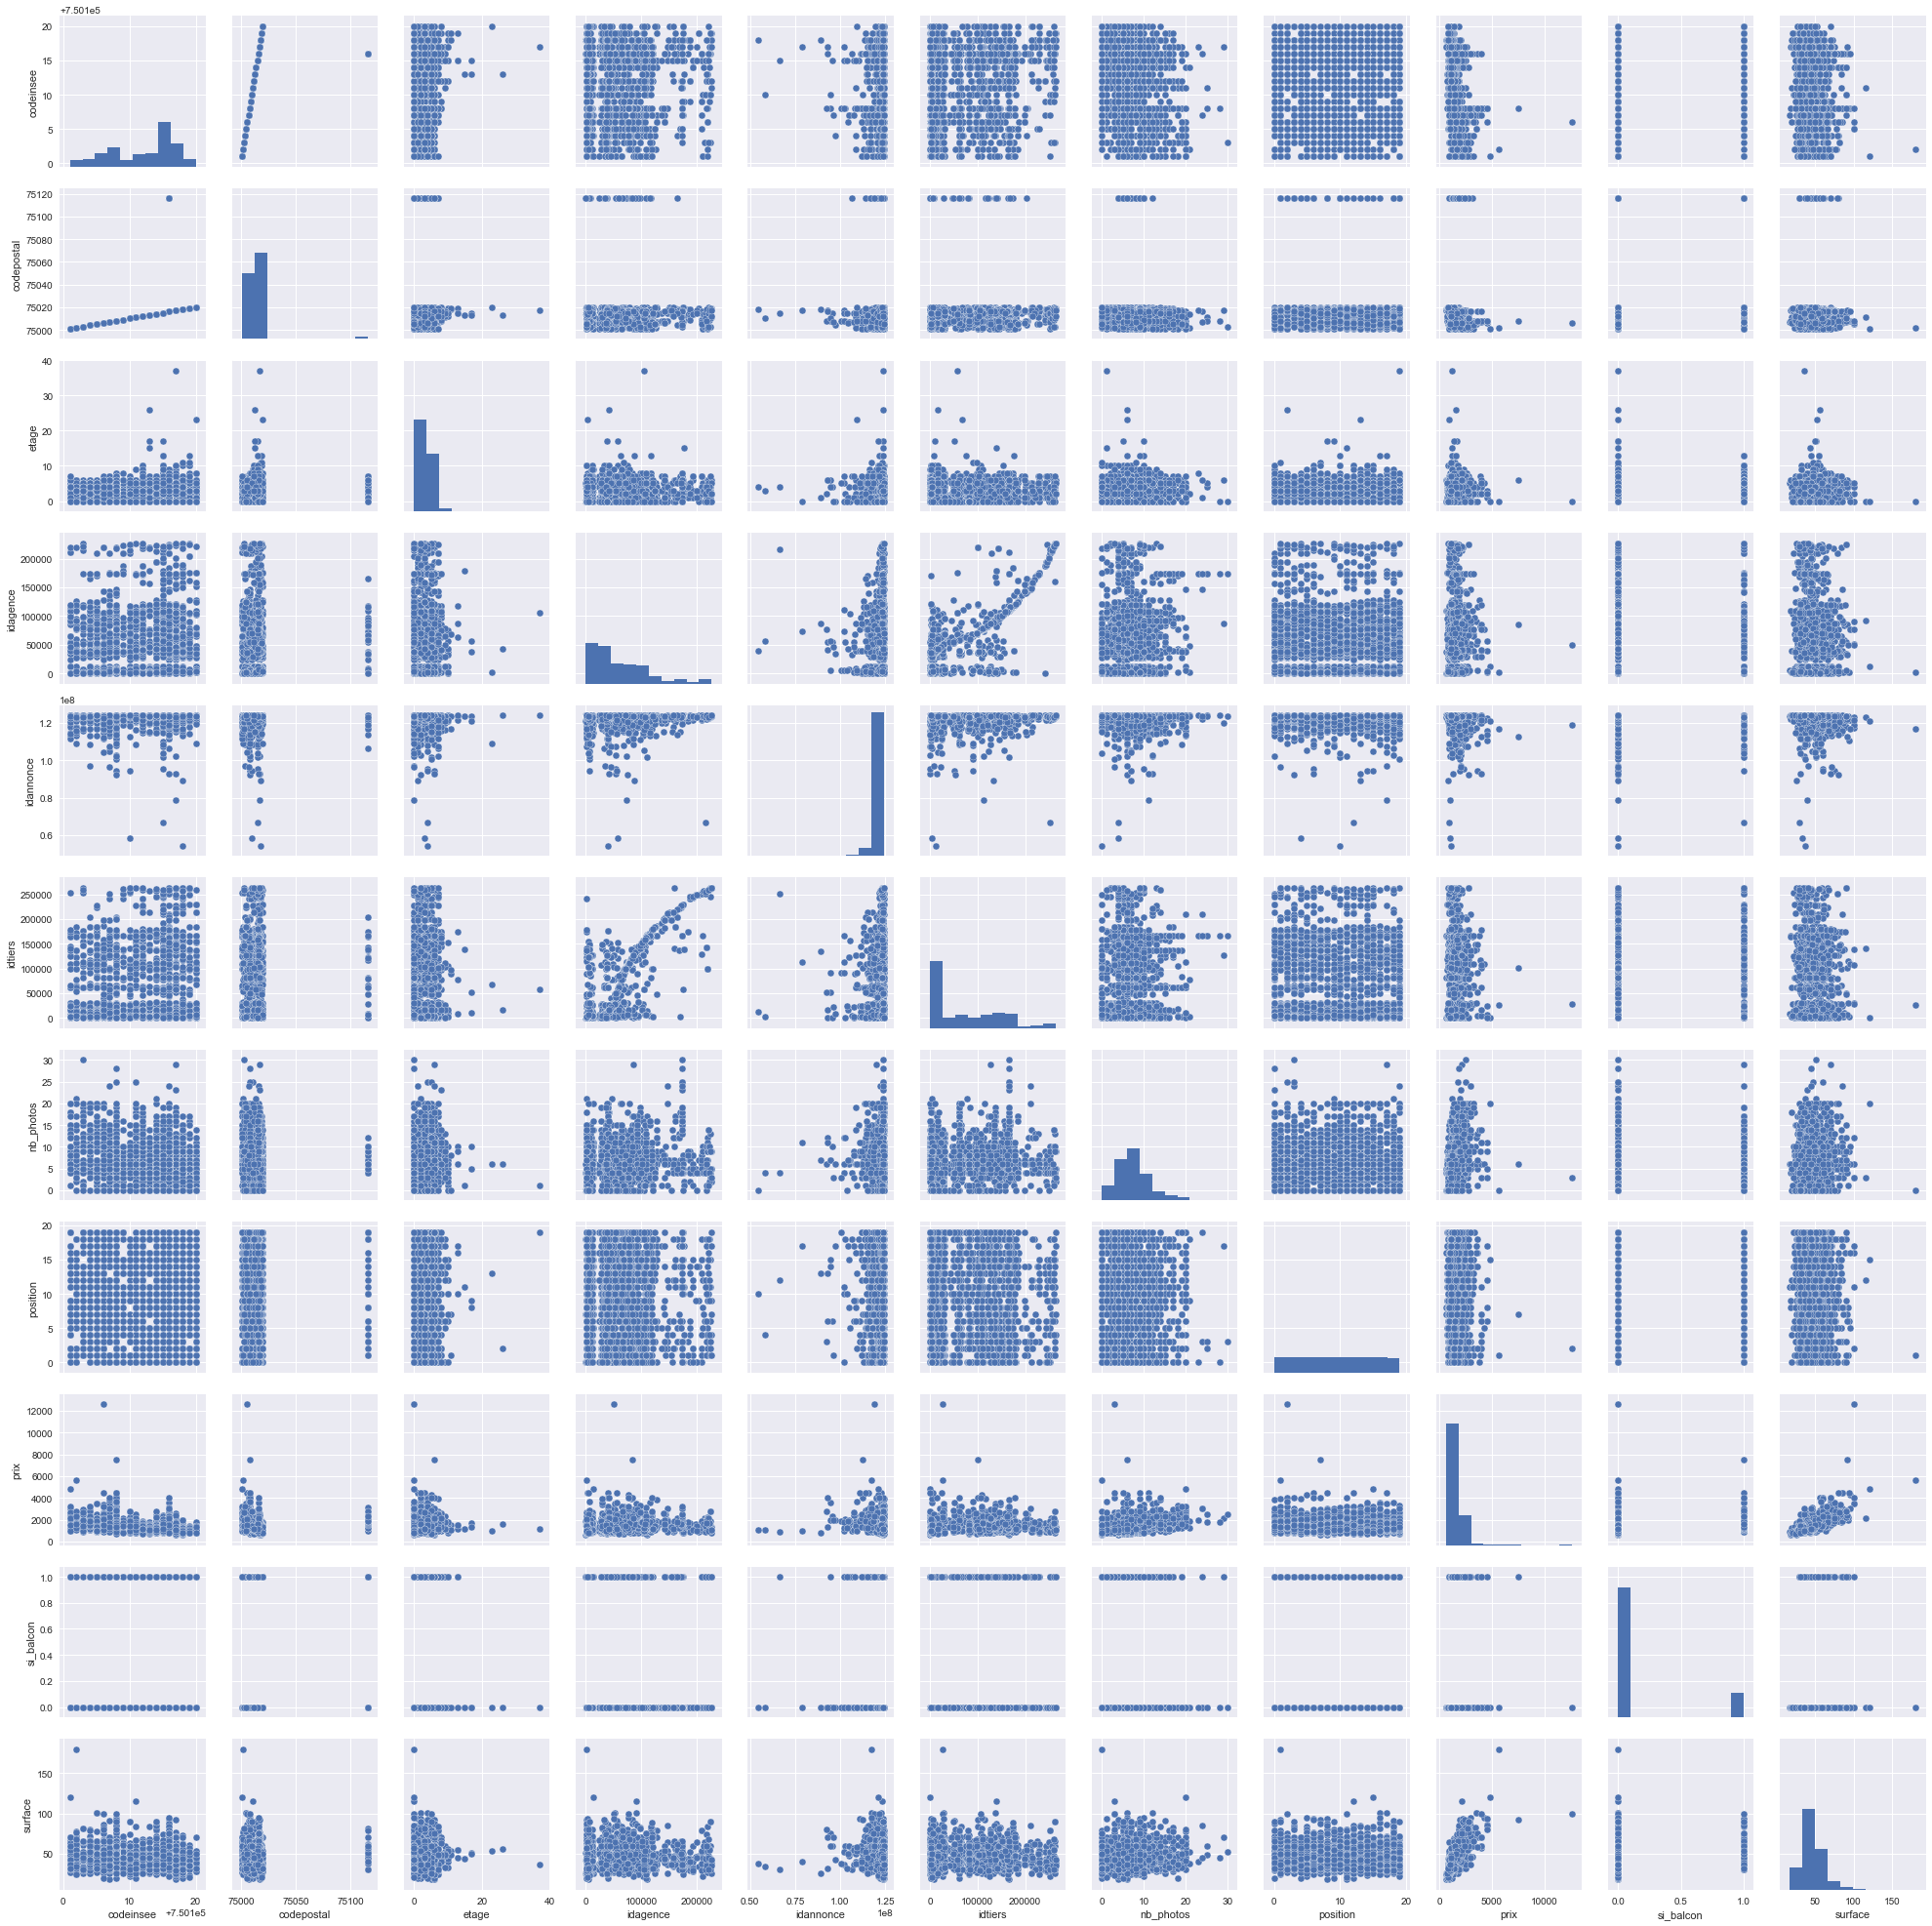

In [32]:
sns.pairplot(df)

This is quite interesting to look at. Let's see if we can uncover some relationships in the data. I can think of a few:

- neighbourhoods: some are better/worse, which should have an impact on the prices
- size of the appartment: larger should be more expensive
- which floor the appartment is one: lower is better?
- balconies: appartments with balconies are more expensive?

Let's look at all these.

## Neighboorhoods 

In [33]:
df['surface_group'] = pd.cut(df.surface, range(0, 100, 20))

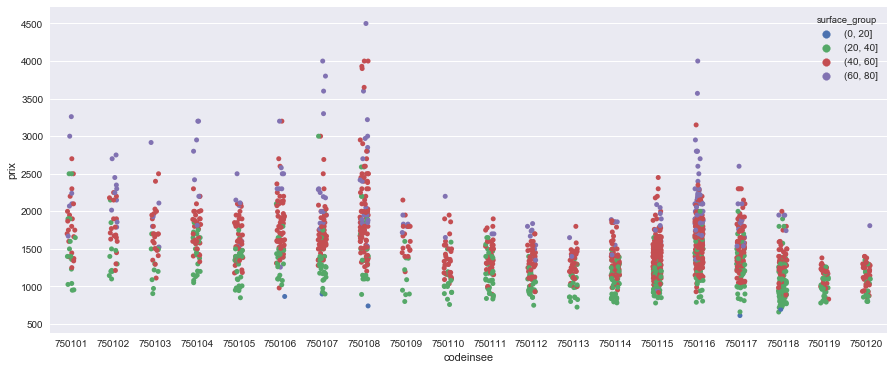

In [34]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.stripplot(x="codeinsee", y="prix", hue='surface_group', data=df, jitter=True, ax=ax);

It seems that some neighboorhoods are indeed better than others, since same size appartments are more expensive there. Let's plot the distribution to see that in more detail.

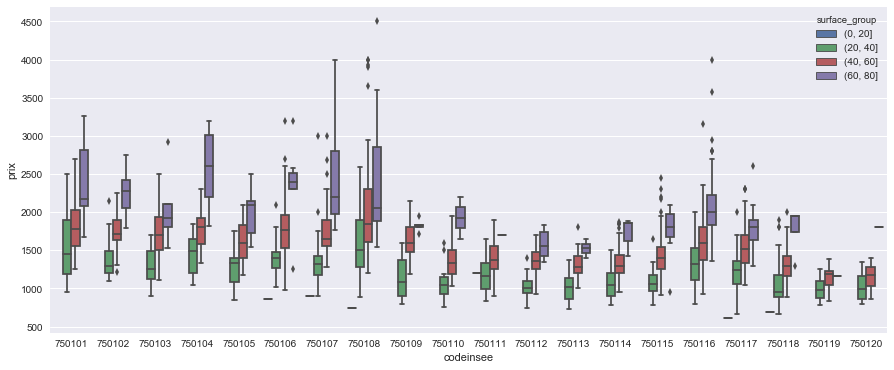

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x="codeinsee", y="prix", hue='surface_group', data=df, ax=ax);

We could rank neighboorhoods according to one category of appartment sizes.

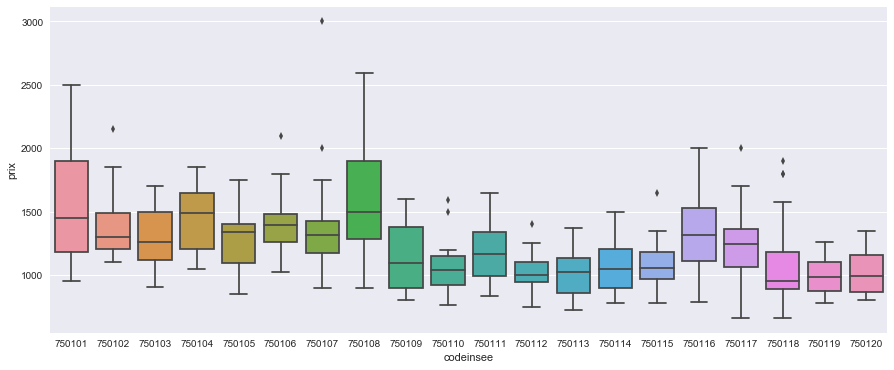

In [36]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x="codeinsee", y="prix", data=df[df.surface_group == df.surface_group.cat.categories[1]], ax=ax);

Here, it seems the 1st, 3rd, 4th and 8th arrondissement are the most coveted.

Let's plot this as a pivot table.

In [37]:
pivot_table = df.pivot_table(index='codeinsee', columns=['surface_group'], values='prix')
pivot_table

surface_group,"(0, 20]","(20, 40]","(40, 60]","(60, 80]"
codeinsee,,,,
750101,NaN,1550.812500,1829.450000,2390.000000
750102,NaN,1412.727273,1768.058824,2261.000000
750103,NaN,1287.800000,1720.636364,2056.200000
750104,NaN,1447.913043,1763.064516,2597.875000
750105,NaN,1265.758621,1629.700000,1999.500000
750106,867.0,1393.840000,1802.258621,2367.125000
750107,900.0,1378.093750,1744.038462,2487.733333
750108,741.0,1606.517241,2026.939024,2435.476190
750109,NaN,1134.444444,1631.058824,1825.600000


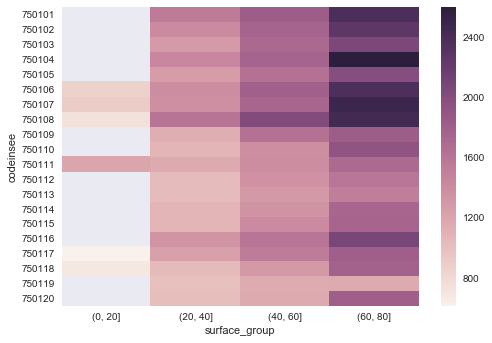

In [38]:
sns.heatmap(pivot_table)

In [39]:
geo_df = pd.DataFrame({'id': [i for i in range(1, 21)], 
                       'prix': pivot_table[30].values})
geo_df.head()

,id,prix
0,1,1550.812500
1,2,1412.727273
2,3,1287.800000
3,4,1447.913043
4,5,1265.758621


In [40]:
import folium

In [41]:
m = folium.Map(location=[48.87, 2.35], zoom_start=12)
m.choropleth(
    geo_data='https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/paris.geojson',
    key_on='feature.properties.cartodb_id',
    data=geo_df,
    columns=['id', 'prix'],
    fill_color='OrRd', 
    threshold_scale=[0, 900, 1100, 1300, 1500, 1700],
    highlight=True)
m

## Appartment sizes 

Let's see if we can make out a relationship trend between appartment surface and price.

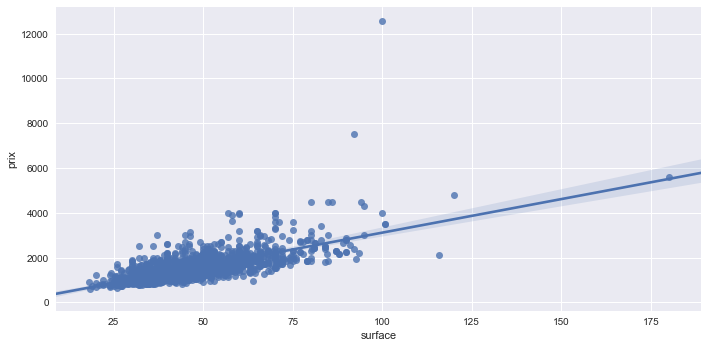

In [42]:
sns.lmplot(x='surface', y='prix', data=df, aspect=2)

As expected, the trend goes up.
How does this look like among neighboorhoods?

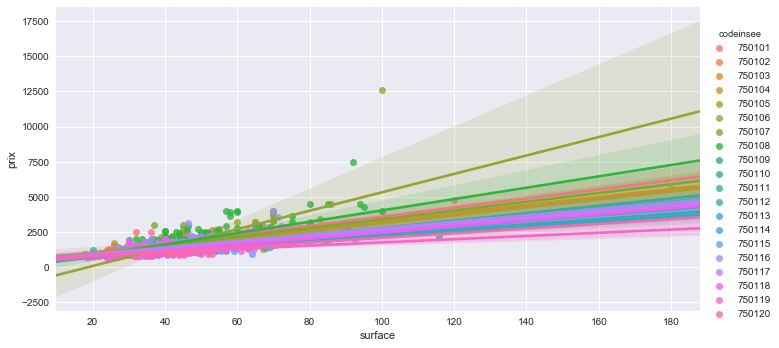

In [43]:
sns.lmplot(x='surface', y='prix', hue='codeinsee', data=df, aspect=2)

This is a surprising curve: the regression coefficient clearly depends on the neighboorhood location! Let's do a choropleth map of the regression coefficient.

First, let's compute the regression lines by hand using scikit-learn.

In [44]:
from sklearn.linear_model import LinearRegression

In [45]:
coefs = {}
for code in df.codeinsee.unique():
    x = df[df.codeinsee == code]['surface']
    y = df[df.codeinsee == code]['prix']
    reg = LinearRegression()
    reg.fit(x[:, np.newaxis], y[:, np.newaxis])
    coefs[int(str(code)[-2:]) - 1] = reg.coef_[0][0]

In [46]:
geo_df = pd.concat([geo_df['id'], geo_df['prix'], pd.Series(coefs, name='coef')], axis=1)

In [47]:
geo_df.head()

,id,prix,coef
0,1,1550.812500,32.384756
1,2,1412.727273,27.892517
2,3,1287.800000,28.215213
3,4,1447.913043,28.349866
4,5,1265.758621,28.509817


In [48]:
geo_df.describe()

,id,prix,coef
count,20.00000,20.000000,20.000000
mean,10.50000,1226.727184,26.145085
std,5.91608,192.131252,11.392574
min,1.00000,988.904762,11.407384
25%,5.75000,1063.638124,20.269739
50%,10.50000,1200.884286,23.244399
75%,15.25000,1382.030313,28.389854
max,20.00000,1606.517241,65.560504


Now, let's plot the coefficient:

In [49]:
m = folium.Map(location=[48.87, 2.35], zoom_start=12)
m.choropleth(
    geo_data='https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/paris.geojson',
    key_on='feature.properties.cartodb_id',
    data=geo_df,
    columns=['id', 'coef'],
    fill_color='BuPu', 
    threshold_scale=[10, 20, 30, 40],
    legend_name='coefficient de croissance (€/m^2)',
    highlight=True)
m

## Floors 

Let's see where the floors are distributed in the city.

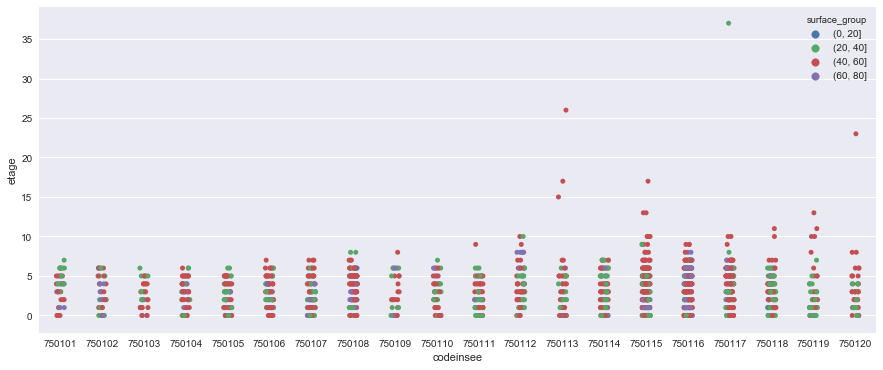

In [50]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.stripplot(x="codeinsee", y="etage", hue='surface_group', data=df, jitter=True, ax=ax);

What's the distribution of floor size and price?

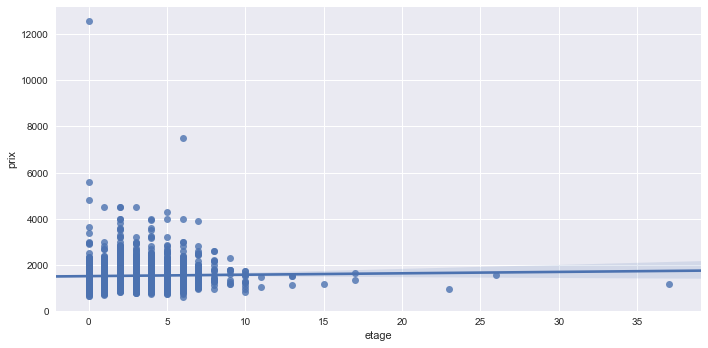

In [51]:
sns.lmplot(x='etage', y='prix', data=df, aspect=2)

Almost no dependence on floors. However, a linear model is probably not the best way to represent the data, so I'm not sure this is a good conclusion.

Let's see how this varies with the neighboorhoods.

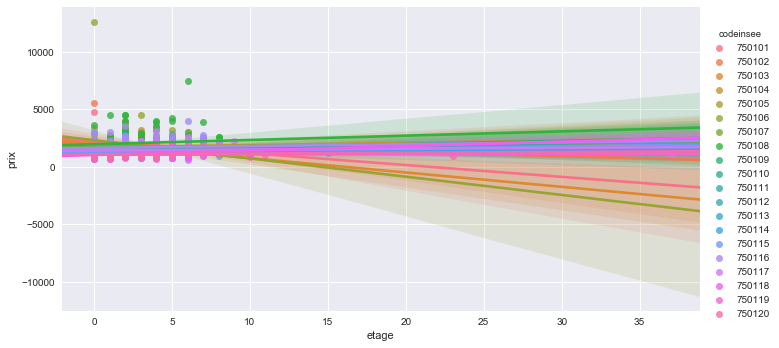

In [52]:
sns.lmplot(x='etage', y='prix', hue='codeinsee', data=df, aspect=2)

Interesting: the model is really bad when extrapolated to non existing floor sizes (most buildings in Paris have a height of four stories).

## Balconies 

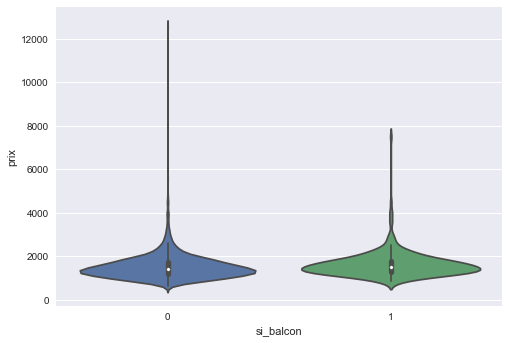

In [53]:
sns.violinplot(x='si_balcon', y='prix', data=df, aspect=2)

Apparently, balconies are worth a little extra money.

# Conclusions

In this notebook, we scraped a website for its data to create a dataset that we analyzed with plots, choropleths and linear regressions. With this data, you could do lots of things. For instance train a machine learning model so that you can price your appartment easily, or do more detailed choropleths to analyze the influence of points of interest. You could even build a system that stores this data daily so that you can have a historical point of view on the development of the market. 

I'll conclude with a tweet that I read some time ago and that fits with the spirit of this exploration.

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">IMO: Data/ML projects are 10x more interesting if they involve lots of web scraping</p>&mdash; Erik Bernhardsson (@fulhack) <a href="https://twitter.com/fulhack/status/841035758450405380">March 12, 2017</a></blockquote> <script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

*This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20170919_ParisAppartmentChoropleth.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20170919_ParisAppartmentChoropleth.ipynb).*